In [1]:
"""
--------------------------------------------------------------------------------
Project: WaveCNNTransformer Pipeline
Developer: Erfan Zabeh
Email: erfanzabeh1@gmail.com
Date: February 2025
Description: 
    This script is part of a modular pipeline for a CNN-Transformer model 
    to classify wave data. It includes model definitions, a training pipeline, 
    and a runnable entry point.
--------------------------------------------------------------------------------
"""

'\n--------------------------------------------------------------------------------\nProject: WaveCNNTransformer Pipeline\nDeveloper: Erfan Zabeh\nEmail: erfanzabeh1@gmail.com\nDate: February 2025\nDescription: \n    This script is part of a modular pipeline for a CNN-Transformer model \n    to classify wave data. It includes model definitions, a training pipeline, \n    and a runnable entry point.\n--------------------------------------------------------------------------------\n'

Prepare the dataset


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Load saved data
directory = '/Users/Erfan/Desktop/BISC_Data'
file_name = 'matched_data.npz'
output_path = f"{directory}/{file_name}"

data = np.load(output_path)
Y_matched = data['Y_matched']  
Z_matched = data['Z_matched'] 
locations_matched = data['locations_matched'] 

wave_data = np.stack((Y_matched, Z_matched), axis=-1)  
wave_data = np.transpose(wave_data, (2, 1, 0, 3))  
wave_data = wave_data.astype(np.float32)
locations_matched = locations_matched.astype(np.float32)

# Downsample data to reduce size
wave_data = wave_data[:, :wave_data.shape[1] - (wave_data.shape[1] % 25), :, :].reshape(
    wave_data.shape[0], -1, 25, wave_data.shape[2], wave_data.shape[3]
).mean(axis=2)
locations_matched = locations_matched[:, ::25, :]  # Downsample locations

print(f"wave_data shape: {wave_data.shape}")  
print(f"locations_matched shape: {locations_matched.shape}")  

# dynamic location limits
x_min, x_max = locations_matched[..., 0].min(), locations_matched[..., 0].max()
y_min, y_max = locations_matched[..., 1].min(), locations_matched[..., 1].max()
location_limits = (x_min, x_max, y_min, y_max)
print(f"Calculated location limits: {location_limits}")

# discretization function
def discretize_locations(locations, grid_size, location_limits):
    x_min, x_max, y_min, y_max = location_limits
    x_bins = np.linspace(x_min, x_max, grid_size[0] + 1)
    y_bins = np.linspace(y_min, y_max, grid_size[1] + 1)

    x_indices = np.digitize(locations[..., 0], x_bins) - 1
    y_indices = np.digitize(locations[..., 1], y_bins) - 1

    # Clamp indices to valid range
    x_indices = np.clip(x_indices, 0, grid_size[0] - 1)
    y_indices = np.clip(y_indices, 0, grid_size[1] - 1)

    # Combine x and y indices into a single grid index
    grid_indices = x_indices * grid_size[1] + y_indices
    return grid_indices

#Split the data into training and testing
num_trials = locations_matched.shape[0]
indices = np.arange(num_trials)
np.random.shuffle(indices)

train_indices = indices[:int(0.8 * num_trials)]
test_indices = indices[int(0.8 * num_trials):]

train_wave_data = wave_data[train_indices]
test_wave_data = wave_data[test_indices]
train_locations = locations_matched[train_indices]
test_locations = locations_matched[test_indices]


train_grid_indices = discretize_locations(train_locations, grid_size=(12, 12), location_limits=location_limits)
test_grid_indices = discretize_locations(test_locations, grid_size=(12, 12), location_limits=location_limits)

# # Debugging: Check the grid indices
# print(f"Sample train grid indices:\n{train_grid_indices[:5]}")
# print(f"Sample test grid indices:\n{test_grid_indices[:5]}")

# Step 5: Define Dataset Class
class WaveDataset(torch.utils.data.Dataset):
    def __init__(self, wave_data, grid_indices):
        self.wave_data = wave_data
        self.grid_indices = grid_indices

    def __len__(self):
        return len(self.wave_data)

    def __getitem__(self, idx):
        wave_tensor = torch.tensor(self.wave_data[idx], dtype=torch.float32)
        grid_index_tensor = torch.tensor(self.grid_indices[idx], dtype=torch.long)
        return wave_tensor, grid_index_tensor


train_dataset = WaveDataset(train_wave_data, train_grid_indices)
test_dataset = WaveDataset(test_wave_data, test_grid_indices)


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# # Verify DataLoader creation
# print(f"Train Loader Batch Count: {len(train_loader)}")
# print(f"Test Loader Batch Count: {len(test_loader)}")

# # Debug: Print a sample from the dataset
# for wave_tensor, grid_index in train_loader:
#     print("Sample wave tensor shape:", wave_tensor.shape)  # [batch_size, time, electrodes, channels]
#     # print("Sample grid indices:", grid_index)  # [batch_size]
#     break



wave_data shape: (401, 40, 1008, 2)
locations_matched shape: (401, 40, 2)
Calculated location limits: (878.0, 1230.0, 553.0, 905.0)


Define Netowrk

In [3]:
'''''
Load the saved netwroks and modules
'''''
# # Step 1: Import the Modules
# from wave_pipeline import WaveCNNTransformerPipeline
# from utils import load_your_data

# # Step 2: Load Data
# wavetrain, wavetest, train_indices, test_indices = load_your_data()

# # Step 3: Run the Pipeline
# pipeline = WaveCNNTransformerPipeline(
#     wavetrain,
#     wavetest,
#     train_indices,
#     test_indices
# )
# pipeline.run(num_epochs=1000)

# # Step 4: Viewing Results
# # Metrics and model outputs are generated automatically.
# # Check saved model file: "wave_transformer_classifier.pth"

# # Hint to Run:
# # To execute the pipeline from the terminal:
# # python run_pipeline.py


"''\nLoad the saved netwroks and modules\n"

In [ ]:
'''''
Direct Test and Change of Network Model
'''''
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Check and set the device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

def normalize_data(wave_data):
    mean = wave_data.mean(axis=(1, 2, 3), keepdims=True)
    std = wave_data.std(axis=(1, 2, 3), keepdims=True)
    return (wave_data - mean) / std

train_wave_data = normalize_data(train_wave_data)
test_wave_data = normalize_data(test_wave_data)

# If requires retrating: 

# # Model Initialization
# model = WaveTransformerClassifier(
#     d_model=256,
#     nhead=4,
#     num_layers=4,
#     hidden_dim=8,
#     num_classes=144,
#     dropout=0.00001
# ).to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.99)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001, weight_decay=10)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


# # Training
# train_losses, test_losses, train_accuracies, test_accuracies = train_model(
#     model, train_loader, test_loader, optimizer, scheduler, num_epochs=30
# )

# # Visualization
# plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies)

# Save the model for future use
torch.save(model.state_dict(), "wave_transformer_classifier.pth")
print("Model saved successfully.")


In [ ]:
# If trained
import torch
from HybridModel import WaveTransformerClassifier  # Import your model definition
model = WaveTransformerClassifier(
    d_model=256,
    nhead=4,
    num_layers=4,
    hidden_dim=8,
    num_classes=144,
    dropout=0.00001
).to(device)
# Load the saved model weights
model.load_state_dict(torch.load("wave_transformer_classifier.pth"))
# Set the model to evaluation mode
model.eval()

print("Model loaded successfully and ready for inference.")

In [19]:
def evaluate_model(model, data_loader):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            logits = model(inputs)  # Get logits from the model
            predictions = torch.argmax(logits, dim=-1)  # Convert logits to predicted grid indices
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Concatenate predictions and targets across all batches
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    return all_predictions, all_targets


# Evaluate model on training and testing datasets
train_predictions, train_targets = evaluate_model(model, train_loader)
test_predictions, test_targets = evaluate_model(model, test_loader)


In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def visualize_predictions(grid_predictions, grid_targets, location_limits, grid_size, trial_index):
    """
    Visualize predictions:
    1. Discretized grid indices (true vs. predicted)
    2. Reverted locations (true vs. predicted locations)
    """
    x_min, x_max, y_min, y_max = location_limits

    def grid_to_location(grid_indices):
        x_bins = np.linspace(x_min, x_max, grid_size[0] + 1)
        y_bins = np.linspace(y_min, y_max, grid_size[1] + 1)
        x_indices = grid_indices // grid_size[1]
        y_indices = grid_indices % grid_size[1]
        x_coords = (x_bins[x_indices] + x_bins[x_indices + 1]) / 2
        y_coords = (y_bins[y_indices] + y_bins[y_indices + 1]) / 2
        return np.stack([x_coords, y_coords], axis=-1)

    pred_trial = grid_predictions[trial_index]
    target_trial = grid_targets[trial_index]

    pred_locations = grid_to_location(pred_trial)
    target_locations = grid_to_location(target_trial)

    plt.figure(figsize=(8, 2))
    plt.plot(range(len(target_trial)), target_trial, label="True Grid Indices", color='blue', marker='o')
    plt.plot(range(len(pred_trial)), pred_trial, label="Predicted Grid Indices", color='orange', linestyle='--', marker='x')
    plt.xlabel("Time Step")
    plt.ylabel("Grid Index")
    plt.title(f"Discretized Grid Indices (Trial {trial_index + 1})")
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()

    plt.figure(figsize=(4, 4))
    plt.scatter(target_locations[:, 0], target_locations[:, 1], label="True Locations", color='blue', alpha=0.7, marker='o')
    plt.scatter(pred_locations[:, 0], pred_locations[:, 1], label="Predicted Locations", color='orange', alpha=0.7, marker='x')
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title(f"Reverted Locations (Trial {trial_index + 1})")
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()


In [ ]:
def plot_accuracy_heatmap(class_predictions, grid_targets, grid_size, location_limits):
    """
    Plots a heatmap of prediction accuracy per grid cell.
    
    Args:
        class_predictions (np.ndarray): Predicted grid indices from the model.
        grid_targets (np.ndarray): True grid indices from the dataset.
        grid_size (tuple): Size of the grid (rows, columns).
        location_limits (tuple): Limits of the locations (x_min, x_max, y_min, y_max).
    """
    accuracy_grid = np.zeros(grid_size)
    total_counts = np.zeros(grid_size)

    def decode_grid_index(idx, grid_size):
        row = idx // grid_size[1]
        col = idx % grid_size[1]
        return row, col

    for pred_idx, true_idx in zip(class_predictions.flatten(), grid_targets.flatten()):
        true_row, true_col = decode_grid_index(true_idx, grid_size)
        pred_row, pred_col = decode_grid_index(pred_idx, grid_size)
        
        total_counts[true_row, true_col] += 1
        if true_row == pred_row and true_col == pred_col:
            accuracy_grid[true_row, true_col] += 1

    # Compute accuracy per cell
    accuracy_grid = np.divide(
        accuracy_grid, total_counts, 
        out=np.zeros_like(accuracy_grid), 
        where=total_counts > 0
    )

    x_min, x_max, y_min, y_max = location_limits
    plt.figure(figsize=(4, 3))
    plt.imshow(
        accuracy_grid, cmap="viridis", origin="lower",
        extent=(x_min, x_max, y_min, y_max)
    )
    plt.colorbar(label="Prediction Accuracy")
    plt.title("Prediction Accuracy Heatmap")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(alpha=0.5)
    plt.show()


train_predictions, train_targets = evaluate_model(model, train_loader)
test_predictions, test_targets = evaluate_model(model, test_loader)

grid_size = (12, 12)
location_limits = (878, 1230, 553, 905) 

print("Training Data Accuracy Heatmap:")
plot_accuracy_heatmap(train_predictions, train_targets, grid_size, location_limits)

print("Testing Data Accuracy Heatmap:")
plot_accuracy_heatmap(test_predictions, test_targets, grid_size, location_limits)


In [ ]:
from matplotlib.colors import LinearSegmentedColormap
def plot_advanced_accuracy_heatmap(class_predictions, grid_targets, grid_size, location_limits, neighbor_radius=2):
    """
    Plots a heatmap of prediction accuracy per grid cell, considering predictions valid 
    if they fall within a radius of neighbor_radius pixels around the true target location.
    
    Args:
        class_predictions (np.ndarray): Predicted grid indices from the model.
        grid_targets (np.ndarray): True grid indices from the dataset.
        grid_size (tuple): Size of the grid (rows, columns).
        location_limits (tuple): Limits of the locations (x_min, x_max, y_min, y_max).
        neighbor_radius (int): Radius of neighboring pixels to consider as valid predictions.
    """
    accuracy_grid = np.zeros(grid_size)
    total_counts = np.zeros(grid_size)

    def decode_grid_index(idx, grid_size):
        row = idx // grid_size[1]
        col = idx % grid_size[1]
        return row, col

    for pred_idx, true_idx in zip(class_predictions.flatten(), grid_targets.flatten()):
        true_row, true_col = decode_grid_index(true_idx, grid_size)
        pred_row, pred_col = decode_grid_index(pred_idx, grid_size)

        # Update total counts
        total_counts[true_row, true_col] += 1

        # Check if prediction falls within the neighbor radius
        row_diff = abs(true_row - pred_row)
        col_diff = abs(true_col - pred_col)
        if row_diff <= neighbor_radius and col_diff <= neighbor_radius:
            accuracy_grid[true_row, true_col] += 1

    # Compute accuracy per cell
    accuracy_grid = np.divide(
        accuracy_grid, total_counts, 
        out=np.zeros_like(accuracy_grid), 
        where=total_counts > 0
    )

    # Plot the heatmap
    colors = ["gray","lightgray", "darkred"]
    custom_cmap = LinearSegmentedColormap.from_list("darkred_to_white", colors)

    x_min, x_max, y_min, y_max = location_limits
    plt.figure(figsize=(4, 3))
    plt.imshow(
        accuracy_grid, cmap=custom_cmap, origin="upper",
        extent=(x_min, x_max, y_min, y_max)
    )
    plt.colorbar(label=f"Accuracy (Prediction Radius: {neighbor_radius})")
    plt.title("Prediction Accuracy Heatmap")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    # plt.grid(alpha=0.5)
    plt.show()


train_predictions, train_targets = evaluate_model(model, train_loader)
test_predictions, test_targets = evaluate_model(model, test_loader)

grid_size = (12, 12)
location_limits = (878, 1230, 553, 905)  

print("Training Data Advanced Accuracy Heatmap:")
plot_advanced_accuracy_heatmap(train_predictions, train_targets, grid_size, location_limits, neighbor_radius=2)
print("Testing Data Advanced Accuracy Heatmap:")
plot_advanced_accuracy_heatmap(test_predictions, test_targets, grid_size, location_limits, neighbor_radius=2)


Good Stimulus: Row 6, Col 6, Mean Error: 109.78
Bad Stimulud: Row 11, Col 0, Mean Error: 285.64


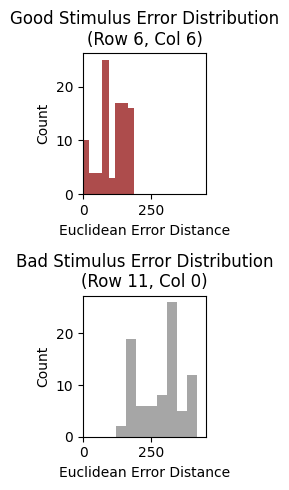

In [ ]:
def plot_error_distribution_for_best_worst(class_predictions, grid_targets, grid_size, location_limits):
    """
    Plots the Euclidean error distance distribution for the best and worst electrodes.

    Args:
        class_predictions (np.ndarray): Predicted grid indices from the model.
        grid_targets (np.ndarray): True grid indices from the dataset.
        grid_size (tuple): Size of the grid (rows, columns).
        location_limits (tuple): Limits of the locations (x_min, x_max, y_min, y_max).
    """
    def decode_grid_index(idx, grid_size, location_limits):
        x_min, x_max, y_min, y_max = location_limits
        row = idx // grid_size[1]
        col = idx % grid_size[1]
        x_bins = np.linspace(x_min, x_max, grid_size[0] + 1)
        y_bins = np.linspace(y_min, y_max, grid_size[1] + 1)
        x = x_bins[col] + (x_bins[1] - x_bins[0]) / 2
        y = y_bins[row] + (y_bins[1] - y_bins[0]) / 2
        return x, y

    errors = np.zeros(grid_size)
    counts = np.zeros(grid_size)

    all_errors = {}  # Store errors for all locations
    for pred_idx, true_idx in zip(class_predictions.flatten(), grid_targets.flatten()):
        true_row, true_col = divmod(true_idx, grid_size[1])
        pred_row, pred_col = divmod(pred_idx, grid_size[1])
        
        true_x, true_y = decode_grid_index(true_idx, grid_size, location_limits)
        pred_x, pred_y = decode_grid_index(pred_idx, grid_size, location_limits)
        
        error = np.sqrt((true_x - pred_x) ** 2 + (true_y - pred_y) ** 2)
        errors[true_row, true_col] += error
        counts[true_row, true_col] += 1

        if (true_row, true_col) not in all_errors:
            all_errors[(true_row, true_col)] = []
        all_errors[(true_row, true_col)].append(error)

    mean_errors = np.divide(errors, counts, out=np.zeros_like(errors), where=counts > 0)

    best_row, best_col = np.unravel_index(np.argmin(mean_errors), grid_size)
    worst_row, worst_col = np.unravel_index(np.argmax(mean_errors), grid_size)

    print(f"Good Stimulus: Row {best_row}, Col {best_col}, Mean Error: {mean_errors[best_row, best_col]:.2f}")
    print(f"Bad Stimulud: Row {worst_row}, Col {worst_col}, Mean Error: {mean_errors[worst_row, worst_col]:.2f}")

    best_errors = all_errors.get((best_row, best_col), [])
    worst_errors = all_errors.get((worst_row, worst_col), [])

    fig, axes = plt.subplots(2,1, figsize=(2,5))
    
    axes[0].hist(best_errors, bins=8, color='darkred', alpha=0.7)
    axes[0].set_title(f"Good Stimulus Error Distribution\n(Row {best_row}, Col {best_col})")
    axes[0].set_xlabel("Euclidean Error Distance")
    axes[0].set_ylabel("Count")
    axes[0].set_xlim([0,450])

    axes[1].hist(worst_errors, bins=8, color='gray', alpha=0.7)
    axes[1].set_title(f"Bad Stimulus Error Distribution\n(Row {worst_row}, Col {worst_col})")
    axes[1].set_xlabel("Euclidean Error Distance")
    axes[1].set_ylabel("Count")
    axes[1].set_xlim([0,450])

    plt.tight_layout()
    plt.show()



train_predictions, train_targets = evaluate_model(model, train_loader)
grid_size = (12, 12)
location_limits = (878, 1230, 553, 905)
plot_error_distribution_for_best_worst(train_predictions, train_targets, grid_size, location_limits)


median plot

In [ ]:
## Find the sample trial:
def find_best_trial(predictions, targets, grid_size, location_limits):
    """
    Finds the trial with the minimum average Euclidean distance between predictions and true locations.

    Args:
        predictions (np.ndarray): Predicted grid indices (shape: [num_trials, num_frames]).
        targets (np.ndarray): True grid indices (shape: [num_trials, num_frames]).
        grid_size (tuple): The grid dimensions (rows, columns).
        location_limits (tuple): Limits of the location space (x_min, x_max, y_min, y_max).

    Returns:
        best_trial_index (int): Index of the best trial.
        min_distance (float): Minimum average Euclidean distance for the best trial.
    """
    def decode_grid_index(index, grid_size, location_limits):
        """Decode grid index into x, y coordinates."""
        row = index // grid_size[1]
        col = index % grid_size[1]
        x_min, x_max, y_min, y_max = location_limits
        x_bins = np.linspace(x_min, x_max, grid_size[0] + 1)
        y_bins = np.linspace(y_min, y_max, grid_size[1] + 1)
        x = (x_bins[col] + x_bins[col + 1]) / 2
        y = (y_bins[row] + y_bins[row + 1]) / 2
        return np.array([x, y])

    num_trials, num_frames = predictions.shape
    avg_distances = []

    for trial in range(num_trials):
        pred_coords = np.array([decode_grid_index(idx, grid_size, location_limits) for idx in predictions[trial]])
        true_coords = np.array([decode_grid_index(idx, grid_size, location_limits) for idx in targets[trial]])
        distances = np.linalg.norm(pred_coords - true_coords, axis=1)  # Compute Euclidean distances
        avg_distance = np.mean(distances)  # Average distance over frames
        avg_distances.append(avg_distance)

    best_trial_index = np.argmin(avg_distances)
    min_distance = avg_distances[best_trial_index]

    return best_trial_index, min_distance

grid_size = (12, 12)
location_limits = (878.0, 1230.0, 553.0, 905.0)

best_trial_index_test, min_distance_test = find_best_trial(test_predictions, test_targets, grid_size, location_limits)
best_trial_index_train, min_distance_train = find_best_trial(train_predictions, train_targets, grid_size, location_limits)


print(f"Best test trial index: {best_trial_index_test}")
print(f"Minimum average Euclidean distance: {min_distance_test:.2f}")

print(f"Best train trial index: {best_trial_index_train}")
print(f"Minimum average Euclidean distance: {min_distance_train:.2f}")


Animation saved to /Users/Erfan/Documents/GitHub/DeepWaveDecoding/Result/final_animation_trial_43.gif


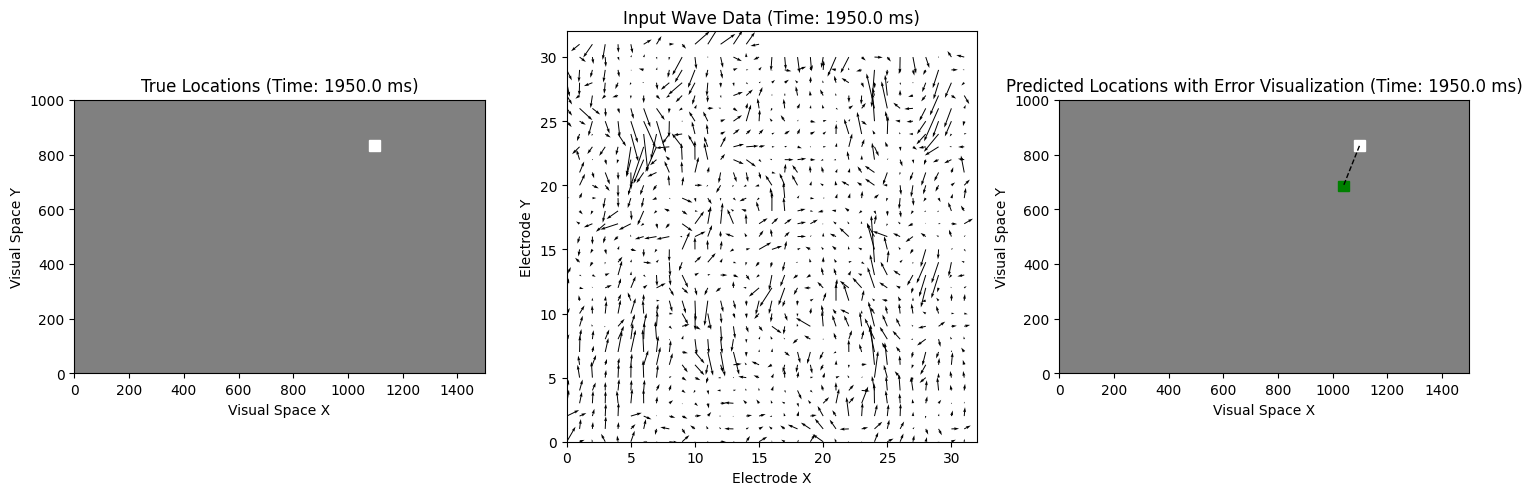

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import numpy as np

# Constants
sampling_rate = 500  # Define the sampling rate in Hz
square_size = 40  # Size of the square for visualization
radius_threshold = 200  # Radius for error classification
directory = '/Users/Erfan/Documents/GitHub/DeepWaveDecoding/Result'

# Decode grid index to X, Y coordinates
def decode_grid_index(index, grid_size, location_limits):
    row = index // grid_size[1]
    col = index % grid_size[1]
    x_min, x_max, y_min, y_max = location_limits
    x_bins = np.linspace(x_min, x_max, grid_size[0] + 1)
    y_bins = np.linspace(y_min, y_max, grid_size[1] + 1)
    x = (x_bins[col] + x_bins[col + 1]) / 2
    y = (y_bins[row] + y_bins[row + 1]) / 2
    return np.array([x, y])

# Dynamically determine electrode positions based on processed data
trial_to_plot_index_in_test = best_trial_index_test  # for test trial index
# trial_to_plot_index_in_test = best_trial_index_train # for train trial index
num_electrodes = wave_data.shape[2]  
grid_dim = int(np.ceil(np.sqrt(num_electrodes)))
x_grid, y_grid = np.meshgrid(np.arange(grid_dim), np.arange(grid_dim))
elec_pos = np.column_stack((x_grid.ravel(), y_grid.ravel()))[:num_electrodes]

# Decode predictions and de-centralize locations
trial_predictions_decoded = np.array([decode_grid_index(idx, (12, 12), location_limits) for idx in test_predictions[trial_to_plot_index_in_test]])
trial_locations_decoded = np.array([decode_grid_index(idx, (12, 12), location_limits) for idx in test_targets[trial_to_plot_index_in_test]])

# # Decode predictions and de-centralize locations
# trial_predictions_decoded = np.array([decode_grid_index(idx, (12, 12), location_limits) for idx in train_predictions[trial_to_plot_index_in_test]])
# trial_locations_decoded = np.array([decode_grid_index(idx, (12, 12), location_limits) for idx in train_targets[trial_to_plot_index_in_test]])


# Select the correspondng trial for wave movie
trial_wave_data = wave_data[trial_to_plot_index_in_test]  # Shape: [40, 1008, 2]
trial_Y = trial_wave_data[:, :, 0]  # Y-components of the vector field
trial_Z = trial_wave_data[:, :, 1]  # Z-components of the vector field

fig, (ax_loc, ax_wave, ax_pred) = plt.subplots(1, 3, figsize=(18, 6))
# Subplot for true locations
ax_loc.set_xlim(0, 1500)
ax_loc.set_ylim(0, 1000)
ax_loc.set_aspect('equal')
ax_loc.set_facecolor("gray")
ax_loc.set_title("True Locations")
ax_loc.set_xlabel("Visual Space X")
ax_loc.set_ylabel("Visual Space Y")
square_loc = plt.Rectangle((0, 0), square_size, square_size, color="white")
ax_loc.add_patch(square_loc)

# Subplot for wave data (unchanged)
ax_wave.set_xlim(0, grid_dim)
ax_wave.set_ylim(0, grid_dim)
ax_wave.set_aspect('equal')
ax_wave.set_facecolor("white")
ax_wave.set_title("Input Wave Data")
ax_wave.set_xlabel("Electrode X")
ax_wave.set_ylabel("Electrode Y")
quiver = ax_wave.quiver(
    elec_pos[:, 0], elec_pos[:, 1],
    trial_Y[0], trial_Z[0],  # Initial vector field
    color='black'
)

# Subplot for predicted locations with error visualization
ax_pred.set_xlim(0, 1500)
ax_pred.set_ylim(0, 1000)
ax_pred.set_aspect('equal')
ax_pred.set_facecolor("gray")
ax_pred.set_title("Predicted Locations with Error Visualization")
ax_pred.set_xlabel("Visual Space X")
ax_pred.set_ylabel("Visual Space Y")
square_true = plt.Rectangle((0, 0), square_size, square_size, color="white", alpha=1)
square_pred = plt.Rectangle((0, 0), square_size, square_size, edgecolor="black", fill=True, linewidth=1)
ax_pred.add_patch(square_true)
ax_pred.add_patch(square_pred)
line_error = ax_pred.plot([], [], color="black", linestyle="--", lw=1)[0]  # Line for error visualization
# ax_pred.add_patch(square_pred)

# Function to compute color based on distance
def get_color_by_distance(distance, threshold):
    if distance <= threshold:
        return "green"
    elif distance <= threshold + 100 :
        return "yellow"
    else:
        return "red"

# Update function for animation
def update(frame):
    time_ms = frame * (1000 / sampling_rate)*25

    # Update true location square
    x_true, y_true = trial_locations_decoded[frame]
    square_true.set_xy((x_true - square_size / 2, y_true - square_size / 2))
    square_loc.set_xy((x_true - square_size / 2, y_true - square_size / 2))
    ax_loc.set_title(f"True Locations (Time: {time_ms:.1f} ms)")

    # Update predicted location square and error line
    x_pred, y_pred = trial_predictions_decoded[frame]
    square_pred.set_xy((x_pred - square_size / 2, y_pred - square_size / 2))
    distance = np.linalg.norm([x_true - x_pred, y_true - y_pred])
    square_pred.set_color(get_color_by_distance(distance, radius_threshold))
    ax_pred.set_title(f"Predicted Locations with Error Visualization (Time: {time_ms:.1f} ms)")

    # Update error line
    line_error.set_data([x_true, x_pred], [y_true, y_pred])
    

    # Update vector field for wave data (unchanged)
    quiver.set_UVC(trial_Y[frame], trial_Z[frame])
    ax_wave.set_title(f"Input Wave Data (Time: {time_ms:.1f} ms)")

    return square_true, square_pred, line_error, quiver

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=trial_Y.shape[0], blit=True)

# Save the animation as a GIF
output_path = f"{directory}/final_animation_trial_{trial_to_plot_index_in_test}.gif"
ani.save(output_path, writer=PillowWriter(fps=4))
print(f"Animation saved to {output_path}")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

sampling_rate = 500  # Define the sampling rate in Hz
time_points = np.arange(len(trial_predictions_decoded)) * (1000 / sampling_rate)  # Time in milliseconds
#Euclidean distance error
errors = trial_predictions_decoded - trial_locations_decoded

# Normalize the errors by the minimum pixel distance
x_min, x_max, y_min, y_max = location_limits
pixel_distance_x = (x_max - x_min) / 12  # Pixel size along X-axis
pixel_distance_y = (y_max - y_min) / 12  # Pixel size along Y-axis
min_pixel_distance = np.sqrt(pixel_distance_x**2 + pixel_distance_y**2)
normalized_errors = errors 

fig, axes = plt.subplots(3, 1, figsize=(8, 4), sharex=True)
# Plot X coordinates (True vs Predicted)
axes[0].plot(time_points, trial_locations_decoded[:, 0], label="True X", color="black",linewidth=2)
axes[0].plot(time_points, trial_predictions_decoded[:, 0], label="Predicted X", color="green", linestyle="--",linewidth=2)
axes[0].set_ylabel("X Coordinate")
# axes[0].legend()
axes[0].set_title("True vs Predicted X Coordinates Across Frames")

# Plot Y coordinates (True vs Predicted)
axes[1].plot(time_points, trial_locations_decoded[:, 1], label="True Y", color="black",linewidth=2)
axes[1].plot(time_points, trial_predictions_decoded[:, 1], label="Predicted Y", color="green", linestyle="--",linewidth=2)
axes[1].set_ylabel("Y Coordinate")
# axes[1].legend()
axes[1].set_title("True vs Predicted Y Coordinates Across Frames")

# Plot normalized Euclidean distance error
axes[2].plot(time_points, normalized_errors[:,1], label="Normalized Error", color="darkred",linestyle="--",linewidth=2,marker = "o")


# axes[2].axhline(y=3*min_pixel_distance, color='green', linestyle='--', linewidth=1, label="Threshold Line")
# axes[2].axhline(y=-3*min_pixel_distance, color='green', linestyle='--', linewidth=1, label="Threshold Line")

surogate_distance = 181
axes[2].axhline(y=surogate_distance, color='gray', linestyle='--', linewidth=1, label="Threshold Line")
axes[2].axhline(y=-surogate_distance, color='gray', linestyle='--', linewidth=1, label="Threshold Line")

axes[2].axhline(y=0, color='gray', linestyle='--', linewidth=1, label="Threshold Line")

axes[2].set_ylabel("Normalized Error")
axes[2].set_xlabel("Time (ms)")
# axes[2].legend()
axes[2].set_xlim([0, 80])
axes[2].set_title("Normalized Euclidean Distance Error Across Frames")

plt.tight_layout()
plt.show()
